In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/trips.csv
/kaggle/input/orders.csv


In [2]:
# IMPORT LIBRARIES
import pandas as pd               # DataFrame support
import numpy as np                # algebra / computations

import matplotlib.pyplot as plt   # plotting
import seaborn as sns             # fancier plotting
%matplotlib inline 


[DAWNLOAD DATA](https://www.kaggle.com/rmarques0/nyc-trips-eda?select=geo_sample.csv)

In [3]:
# IMPORT DATA
orders_filepath = "../input/orders.csv"
trips_filepath = "../input/trips.csv"


# IMPORT DATA
base_trips = pd.read_csv(trips_filepath,
                         engine='c',
                         infer_datetime_format=True, # to speed-up datetime parsing
                         parse_dates=['pickup_datetime', 'dropoff_datetime'])

base_orders = pd.read_csv(orders_filepath, 
                          engine='c',
                          infer_datetime_format=True, 
                          parse_dates=['pickup_datetime'])

In [4]:
# MAKING SAMPLE OF DATA TO SPEEDUP CALC
sample_number = 2000000
strips = base_trips.sample(sample_number)
sorders = base_orders.sample(sample_number)


# CHECK DATA USAGE
print('Memory usage trips, Mb: {:.2f}\n'.format(strips.memory_usage().sum()/2**20))
print('Memory usage orders, Mb: {:.2f}\n'.format(sorders.memory_usage().sum()/2**20))

Memory usage trips, Mb: 244.14

Memory usage orders, Mb: 106.81



In [5]:
# OVERALL INFO
print('Trips Info: ---------------------')
print(strips.info())
print('Orders Info: ---------------------')
print(sorders.info())

#CHECK FOR MISSING VALUES
print(strips.isnull().sum()) 
print(sorders.isnull().sum()) 

Trips Info: ---------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 156617 to 7430118
Data columns (total 15 columns):
order_id             int64
pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
rate_code            int64
dropoff_longitude    float64
dropoff_latitude     float64
payment_type         object
fare_amount          float64
tip_amount           float64
total_amount         float64
passenger_id         int64
driver_id            int64
dtypes: datetime64[ns](2), float64(8), int64(4), object(1)
memory usage: 244.1+ MB
None
Orders Info: ---------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000000 entries, 8494902 to 10801281
Data columns (total 6 columns):
order_id            int64
passenger_id        int64
pickup_datetime     datetime64[ns]
pickup_longitude    float64
pickup_latitude     float64
payment_type        obj

In [6]:
# CHECK FOR DUPLICATES: NO DUPLICATES
print('No of Duplicates, strips - order_id: {}'.format(len(strips) - 
                                              len(strips.drop_duplicates(subset='order_id'))))
print('No of Duplicates, sorders - order_id: {}'.format(len(sorders) - 
                                              len(sorders.drop_duplicates(subset='order_id'))))

# CHECK GEOGRAPHICAL BOUNDS, Latitude: 0.0 to 400.9, Longitude: -171.4 to 121.8
print('strips Latitude bounds: {} to {}'.format(
    max(strips.pickup_latitude.min(), strips.dropoff_latitude.min()),
    max(strips.pickup_latitude.max(), strips.dropoff_latitude.max())
))
print('strips Longitude bounds: {} to {}'.format(
    max(strips.pickup_longitude.min(), strips.dropoff_longitude.min()),
    max(strips.pickup_longitude.max(), strips.dropoff_longitude.max())
))

# COUNT UNIQUE DRIVERS: 50000
print('driver_id   count: {}'.format(len(strips.driver_id.unique())))
# COUNT UNIQUE PASSENGERS
print('driver_id   count: {}'.format(len(strips.passenger_id.unique())))
# DATETIME RANGE - 2014-03-01 00:00:00 to 2014-05-31 18:57:00
print('Datetime range: {} to {}'.format(strips.pickup_datetime.min(), 
                                        strips.dropoff_datetime.max()))


No of Duplicates, strips - order_id: 0
No of Duplicates, sorders - order_id: 0
strips Latitude bounds: 0.0 to 59.137988
strips Longitude bounds: -92.996024 to 1.213851
driver_id   count: 50000
driver_id   count: 1006344
Datetime range: 2014-03-01 00:00:00 to 2014-05-31 02:39:00


In [7]:
# CALCULATE TRIP DURATION IN MINUTES
duration = (strips['dropoff_datetime'] - strips['pickup_datetime']).dt.seconds / 60
strips = strips.assign(trip_duration = duration)

print('Trip duration in minutes: {} to {}'.format(
    strips.trip_duration.min(), strips.trip_duration.max()))


Trip duration in minutes: 0.0 to 1439.9666666666667


In [8]:
outliers=np.array([False]*len(strips))

y = np.array(strips.trip_duration)

#mark outliers  consider only trip_durations btw 1 and 60 minutes
outliers[y>60]=True 
outliers[y<1]=True
print('There are %d entries that have trip duration too long or too short'% sum(outliers))

There are 19691 entries that have trip duration too long or too short


In [9]:
#total of 
strips = strips.assign(outliers=outliers)
#drop outliers
strips_clean = strips[outliers==False]
print('There are %d entries that have trip duration too long or too short'% sum(strips_clean.outliers))

There are 0 entries that have trip duration too long or too short


In [10]:
# NOW THE TRIP DURATION IS CLEAN
# AND ALL THE CALCULATIONS ARE BEING MADE ON SAMPLE DATAFRAME 

Text(0, 0.5, 'frequency')

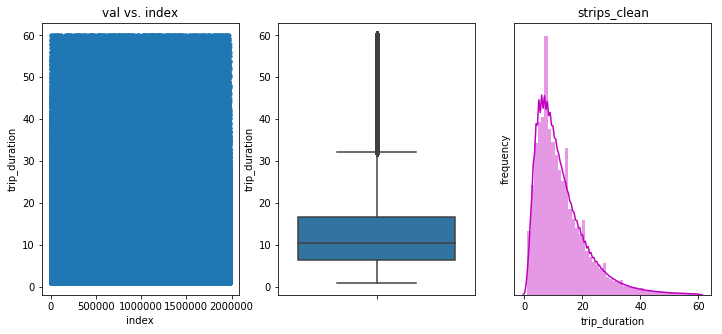

In [11]:
y = np.array(strips_clean.trip_duration)
plt.figure(figsize=(12,5))
plt.subplot(131)
plt.plot(range(len(y)),y,'.');plt.ylabel('trip_duration');plt.xlabel('index');plt.title('val vs. index')
plt.subplot(132)
sns.boxplot(y=strips_clean.trip_duration)
plt.subplot(133)
sns.distplot(y,bins=50, color="m");plt.yticks([]);plt.xlabel('trip_duration');plt.title('strips_clean');plt.ylabel('frequency')
#plt.hist(y,bins=50);

In [12]:
# Remove rides from away area
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
strips_clean = strips_clean[(strips_clean.pickup_longitude> xlim[0]) & (strips_clean.pickup_longitude < xlim[1])]
strips_clean = strips_clean[(strips_clean.dropoff_longitude> xlim[0]) & (strips_clean.dropoff_longitude < xlim[1])]
strips_clean = strips_clean[(strips_clean.pickup_latitude> ylim[0]) & (strips_clean.pickup_latitude < ylim[1])]
strips_clean = strips_clean[(strips_clean.dropoff_latitude> ylim[0]) & (strips_clean.dropoff_latitude < ylim[1])]
longitude = list(strips_clean.pickup_longitude) + list(strips_clean.dropoff_longitude)


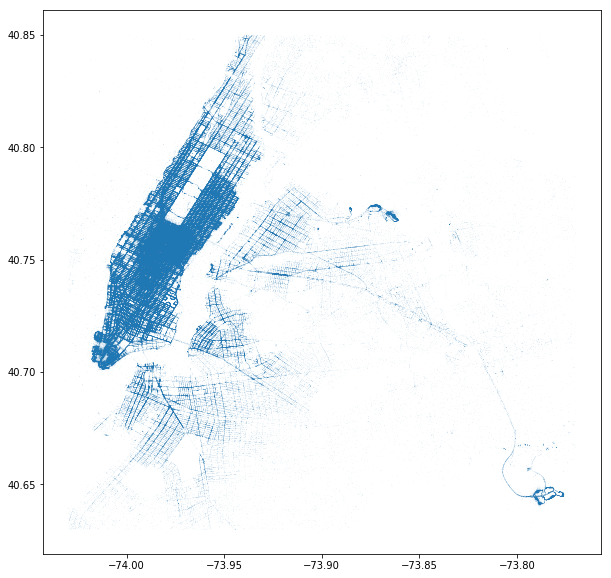

In [13]:
longitude = list(strips_clean.pickup_longitude) + list(strips_clean.dropoff_longitude)
latitude = list(strips_clean.pickup_latitude) + list(strips_clean.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()

In [14]:
loc_strips_clean = pd.DataFrame()
loc_strips_clean['longitude'] = longitude
loc_strips_clean['latitude'] = latitude

In [15]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

kmeans = KMeans(n_clusters=15, random_state=2, n_init = 5).fit(loc_strips_clean)
loc_strips_clean['label'] = kmeans.labels_

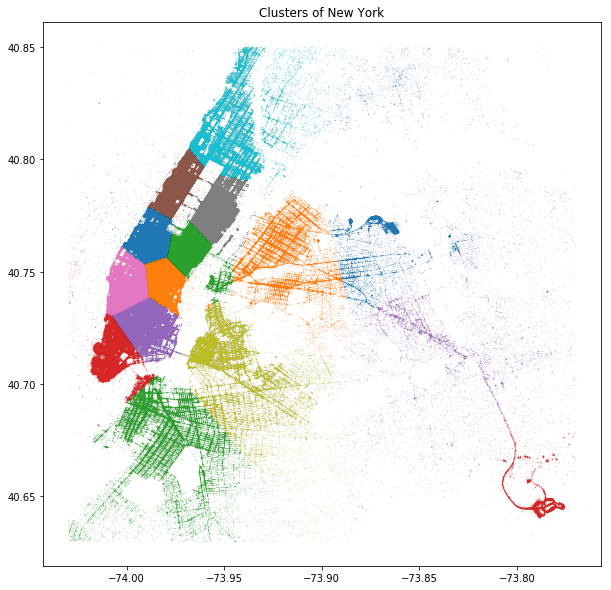

In [16]:
plt.figure(figsize = (10,10))
for label in loc_strips_clean.label.unique():
    plt.plot(loc_strips_clean.longitude[loc_strips_clean.label == label],loc_strips_clean.latitude[loc_strips_clean.label == label],
             '.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

In [17]:
strips_clean.head()

,order_id,pickup_datetime,dropoff_datetime,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,tip_amount,total_amount,passenger_id,driver_id,trip_duration,outliers
156617,7764351,2014-05-16 08:20:54,2014-05-16 08:36:59,1.70,-73.996028,40.762084,1,-73.972127,40.759261,CRD,12.0,1.0,13.50,5234567816608303,5234567812346818,16.083333,False
4560085,11836115,2014-04-29 19:42:32,2014-04-29 19:49:30,1.00,-73.981358,40.750082,1,-73.992494,40.758374,CRD,6.5,1.6,9.60,5234567812363558,5234567812385378,6.966667,False
3360128,6516425,2014-04-08 12:14:41,2014-04-08 12:58:35,3.60,-73.978247,40.766457,1,-73.981652,40.766610,CSH,26.0,0.0,26.50,5234567812393176,5234567812375977,43.900000,False
5785320,2525422,2014-03-15 13:30:00,2014-03-15 14:02:00,10.94,-73.963933,40.756667,1,-73.981085,40.757032,CSH,35.5,0.0,41.33,5234567812378146,5234567812357555,32.000000,False
11006482,1326169,2014-03-01 11:10:18,2014-03-01 11:21:33,2.00,-74.009823,40.712573,1,-73.992762,40.733900,CRD,9.5,2.5,12.50,5234567818083887,5234567812346984,11.250000,False


In [18]:
loc_strips_clean.head()

,longitude,latitude,label
0,-73.996028,40.762084,10
1,-73.981358,40.750082,4
2,-73.978247,40.766457,10
3,-73.963933,40.756667,11
4,-74.009823,40.712573,3


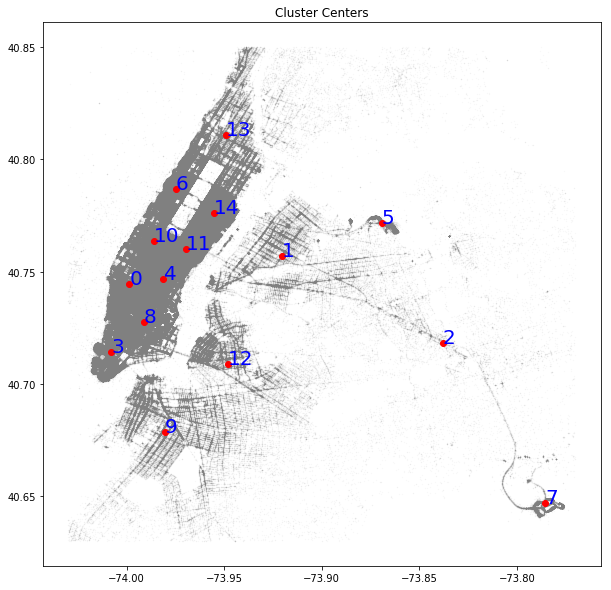

In [19]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_strips_clean.label.unique():
    ax.plot(loc_strips_clean.longitude[loc_strips_clean.label == label],loc_strips_clean.latitude[loc_strips_clean.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [20]:
# MANIPULATING DATE

# DAYS OF WEEK (DOW) MAPPING
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
# MONTHS MAPPING
mm_names = [
    'January', 'February', 'March', 'April']
# MONTH (pickup and dropoff)
strips_clean['mm_pickup'] = strips_clean.pickup_datetime.dt.month.astype(np.uint8)
strips_clean['mm_dropoff'] = strips_clean.dropoff_datetime.dt.month.astype(np.uint8)
# DOW
strips_clean['dow_pickup'] = strips_clean.pickup_datetime.dt.weekday.astype(np.uint8)
strips_clean['dow_dropoff'] = strips_clean.dropoff_datetime.dt.weekday.astype(np.uint8)
# DAY HOUR
strips_clean['hh_pickup'] = strips_clean.pickup_datetime.dt.hour.astype(np.uint8)
strips_clean['hh_dropoff'] = strips_clean.dropoff_datetime.dt.hour.astype(np.uint8)

Text(0, 0.5, 'No of strips_clean made')

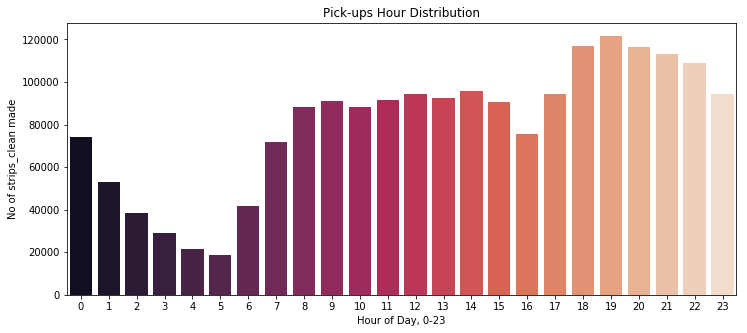

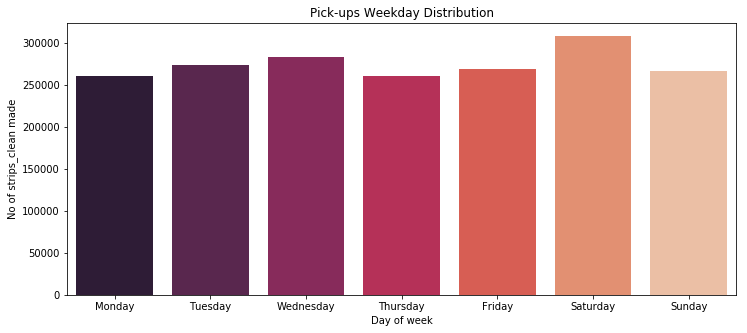

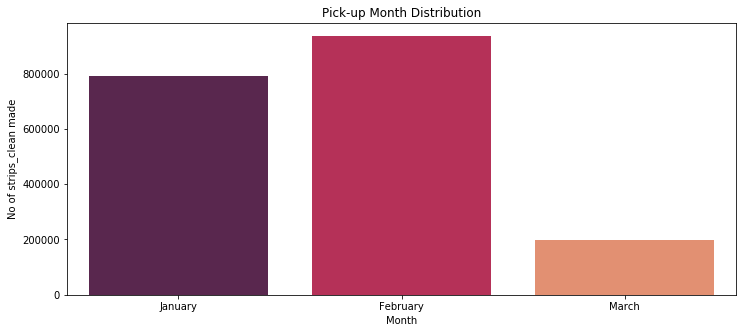

In [21]:
## PICKUPS BY DIFFERENT TIMEFRAMES


# PICKUP COUNT DISTRIBUTION: HOUR OF DAY
plt.figure(figsize=(12,5))
data = strips_clean.groupby('hh_pickup').aggregate({'order_id':'count'}).reset_index()
sns.barplot(x='hh_pickup', y='order_id', data=data, palette="rocket")
plt.title('Pick-ups Hour Distribution')
plt.xlabel('Hour of Day, 0-23')
plt.ylabel('No of strips_clean made')


# PICKUP COUNT DISTRIBUTION: DOW
plt.figure(figsize=(12,5))
data = strips_clean.groupby('dow_pickup').aggregate({'order_id':'count'}).reset_index()
sns.barplot(x='dow_pickup', y='order_id', data=data, palette="rocket")
plt.title('Pick-ups Weekday Distribution')
plt.xlabel('Day of week')
plt.xticks(range(0,7), dow_names, rotation='horizontal')
plt.ylabel('No of strips_clean made')


# PICKUP COUNT DISTRIBUTION: MONTH
plt.figure(figsize=(12,5))
data = strips_clean.groupby('mm_pickup').aggregate({'order_id':'count'}).reset_index()
sns.barplot(x='mm_pickup', y='order_id', data=data, palette="rocket")
plt.title('Pick-up Month Distribution')
plt.xlabel('Month')
plt.xticks(range(0,3), mm_names[:3], rotation='horizontal')
plt.ylabel('No of strips_clean made')




([<matplotlib.axis.YTick at 0x7ff8fad69240>,
 <a list of 4 Text yticklabel objects>)

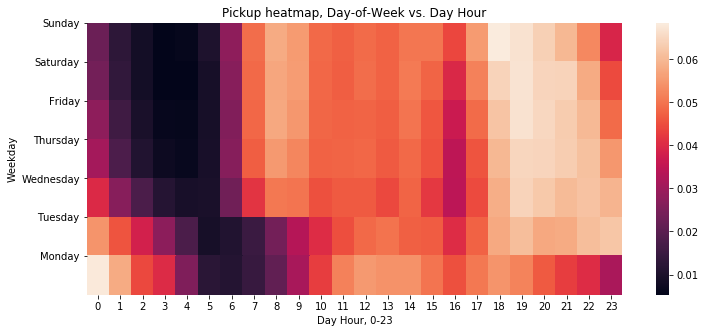

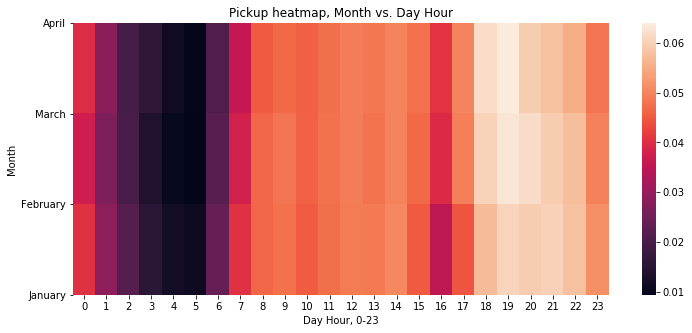

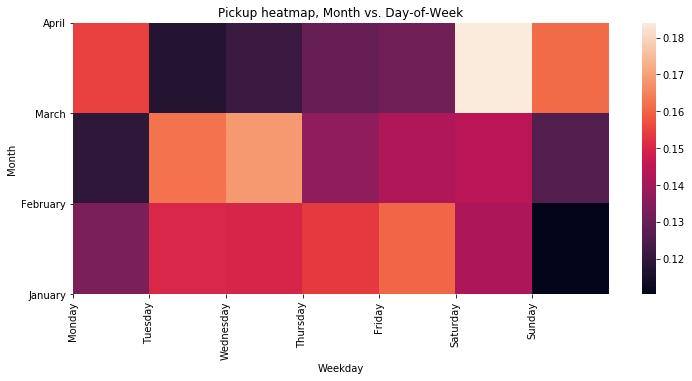

In [22]:
# PICKUP HEATMAP: DOW X HOUR
plt.figure(figsize=(12,5))
sns.heatmap(data=pd.crosstab(strips_clean.dow_pickup, 
                             strips_clean.hh_pickup, 
                             values=strips_clean.order_id, 
                             aggfunc='count',
                             normalize='index'))
plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
plt.ylabel('Weekday') ; plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,7), dow_names[::-1], rotation='horizontal')

# PICKUP HEATMAP: MONTH X HOUR
plt.figure(figsize=(12,5))
sns.heatmap(data=pd.crosstab(strips_clean.mm_pickup, 
                             strips_clean.hh_pickup, 
                             values=strips_clean.order_id, 
                             aggfunc='count',
                             normalize='index'))
plt.title('Pickup heatmap, Month vs. Day Hour')
plt.ylabel('Month') ; plt.xlabel('Day Hour, 0-23')
plt.yticks(range(0,4), mm_names[:4][::-1], rotation='horizontal')

# PICKUP HEATMAP: MONTH X DOW
plt.figure(figsize=(12,5))
sns.heatmap(data=pd.crosstab(strips_clean.mm_pickup, 
                             strips_clean.dow_pickup, 
                             values=strips_clean.order_id, 
                             aggfunc='count',
                             normalize='index'))
plt.title('Pickup heatmap, Month vs. Day-of-Week')
plt.ylabel('Month') ; plt.xlabel('Weekday')
plt.xticks(range(0,7), dow_names, rotation='vertical')
plt.yticks(range(0,4), mm_names[:4][::-1], rotation='horizontal')


In [23]:
strips_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1922125 entries, 156617 to 7430118
Data columns (total 23 columns):
order_id             int64
pickup_datetime      datetime64[ns]
dropoff_datetime     datetime64[ns]
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
rate_code            int64
dropoff_longitude    float64
dropoff_latitude     float64
payment_type         object
fare_amount          float64
tip_amount           float64
total_amount         float64
passenger_id         int64
driver_id            int64
trip_duration        float64
outliers             bool
mm_pickup            uint8
mm_dropoff           uint8
dow_pickup           uint8
dow_dropoff          uint8
hh_pickup            uint8
hh_dropoff           uint8
dtypes: bool(1), datetime64[ns](2), float64(9), int64(4), object(1), uint8(6)
memory usage: 262.1+ MB


In [24]:
print("Total number of cancelled orders file : ", 
      sorders['order_id'].count() - strips_clean['order_id'].count())
print("\n") 


Total number of cancelled orders file :  77875




In [25]:
geo_sample = loc_strips_clean.sample(20000)
geo_output = pd.DataFrame(geo_sample)
trips_output = pd.DataFrame(strips_clean)
orders_output = pd.DataFrame(sorders)



geo_output.to_csv('geo_sample.csv', index=False)
trips_output.to_csv('strips_clean.csv', index=False)
orders_output.to_csv('sorders.csv', index=False)